In [1]:
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.circuits.gate import Gate
from braket.circuits.instruction import Instruction
from braket.circuits.unitary_calculation import calculate_unitary

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    if hasattr(qubits, '__iter__'):
        return qc.h(qubits)
    return qc.h(range(qubits))

In [3]:
n = 2
grover_circuit = Circuit()
grover_circuit = initialize_s(grover_circuit, n)
print(grover_circuit)

T  : |0|
        
q0 : -H-
        
q1 : -H-

T  : |0|


In [4]:
def grover_iteration_U2(grover_circuit):

    grover_circuit.cz(0,1) # Oracle

    #(U_s)
    grover_circuit.h([0,1])
    grover_circuit.z([0,1])
    grover_circuit.cz(0,1)
    grover_circuit.h([0,1])

def complete_circuit(n=2, N_iter=1):
    grover_circuit = Circuit()
    grover_circuit = initialize_s(grover_circuit, [0,1])
    for i in range(N_iter):
        grover_iteration_U2(grover_circuit)
    grover_circuit.density_matrix(target=[0,1])
    return grover_circuit

In [5]:
grover_circuit = complete_circuit(n=2, N_iter=1)
print(grover_circuit)

T  : |0|1|2|3|4|5|Result Types |
                                
q0 : -H-C-H-Z-C-H-DensityMatrix-
        |     |   |             
q1 : -H-Z-H-Z-Z-H-DensityMatrix-

T  : |0|1|2|3|4|5|Result Types |


In [6]:
device = LocalSimulator("default")

result = device.run(grover_circuit, shots=0).result()

dm = result.values[0]

target = np.array([0., 0., 0., 1.])

target.conj().dot(dm).dot(target)

(0.9999999999999991+0j)

In [7]:
def state_fidelity(result, target):
    dm = result.values[0]
    target = np.array(target)
    fid = target.conj().dot(dm).dot(target)
    return fid.real

In [8]:
state_fidelity(result, [0, 0, 0, 1])

0.9999999999999991

In [9]:
N_it_max=10

In [10]:
target_vector = np.array([0.0, 0.0, 0.0, 1.0])

fidelity=[]

for i in range(1, N_it_max):
    grover_circuit = complete_circuit(n=2, N_iter=i)
    result = device.run(grover_circuit, shots=0).result()
    fidelity.append(state_fidelity(result, target_vector))

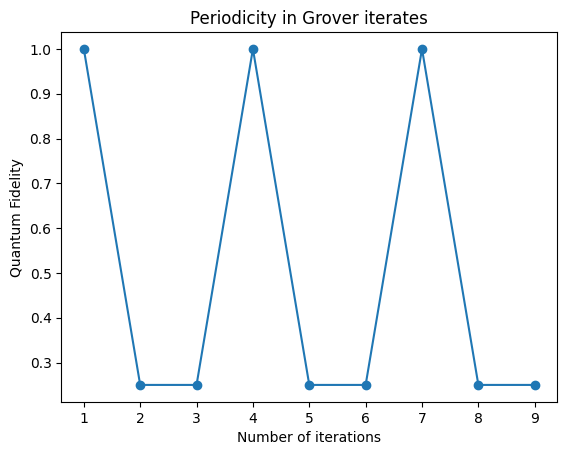

In [11]:
x=range(1,N_it_max)

plt.plot(x, fidelity)

plt.xlabel("Number of iterations")

plt.ylabel("Quantum Fidelity")

plt.title("Periodicity in Grover iterates")

plt.scatter(x, fidelity)
plt.savefig("per_gro_it")
plt.show()

# Fixed point Search

In [12]:
theta=np.pi/3

oracle = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, np.exp(1j*theta)]
])

# Both these operators work since they differ by a global phase
rs = np.array([
    [1, 0, 0, 0],
    [0, np.exp(-1j*theta), 0, 0],
    [0, 0, np.exp(-1j*theta), 0],
    [0, 0, 0, np.exp(-1j*theta)]
])

In [13]:
                        
def fixed_point_grover_instructions(N_iter):


    if N_iter==1:

        instructions = [

            # initial mixed state
            Instruction(Gate.H(), 0),
            Instruction(Gate.H(), 1),

            # 1st iteration
            Instruction(Gate.Unitary(oracle), [0, 1]),

            # (U_s)
            Instruction(Gate.H(), 0),
            Instruction(Gate.H(), 1),
            Instruction(Gate.Unitary(rs), [0, 1]),
            Instruction(Gate.H(), 0),
            Instruction(Gate.H(), 1),
        ]
    
        return instructions
    
    else:
         
        op = calculate_unitary(n, fixed_point_grover_instructions(N_iter-1))

        # adjoint
        adop = np.matrix(op).getH()

        instructions = [
            Instruction(Gate.Unitary(op),     [0, 1]),
            Instruction(Gate.Unitary(oracle), [0, 1]),
            Instruction(Gate.Unitary(adop),   [0, 1]),

            # (U_s)
            Instruction(Gate.Unitary(rs),     [0, 1]),
            Instruction(Gate.Unitary(op),     [0, 1]),
        ]
        return instructions

def fixed_point_grover(N_iter):
    c = Circuit()
    for inst in fixed_point_grover_instructions(N_iter):
        c.add_instruction(inst)
    c.density_matrix(target=[0,1])
    return c

In [14]:
print(fixed_point_grover(1))
print('-'*50)
print(fixed_point_grover(10))

T  : |0|1|2|3|4|Result Types |
                              
q0 : -H-U-H-U-H-DensityMatrix-
        |   |   |             
q1 : -H-U-H-U-H-DensityMatrix-

T  : |0|1|2|3|4|Result Types |
--------------------------------------------------
T  : |0|1|2|3|4|Result Types |
                              
q0 : -U-U-U-U-U-DensityMatrix-
      | | | | | |             
q1 : -U-U-U-U-U-DensityMatrix-

T  : |0|1|2|3|4|Result Types |


In [15]:
N_it_max = 10

fixedgrover = fixed_point_grover(N_it_max)

result = device.run(fixedgrover, shots=0).result()

target_vector = np.array([0.0, 0.0, 0.0, 1.0])

fidelity=[]

for i in range(1, N_it_max):
    fixedgrover = fixed_point_grover(i)
    result = device.run(fixedgrover, shots=0).result()
    fidelity.append(state_fidelity(result, target_vector))

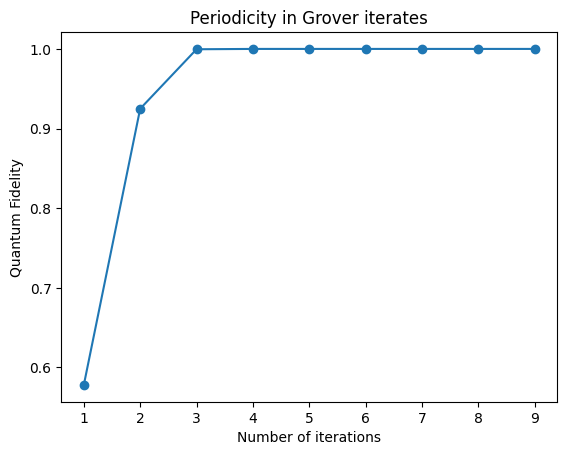

In [16]:
x=range(1,N_it_max)

plt.plot(x, fidelity)

plt.xlabel("Number of iterations")

plt.ylabel("Quantum Fidelity")

plt.title("Periodicity in Grover iterates")

plt.scatter(x, fidelity)
plt.savefig("per_gro_it")
plt.show()